In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Preparing Data

In [3]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Masalembo")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1998-10-30 04:00:00,1,0.250,3.278009
1,1998-10-30 05:00:00,2,0.250,2.625278
2,1998-10-30 06:00:00,3,0.250,2.227879
3,1998-10-30 07:00:00,4,0.250,2.528553
4,1998-10-30 08:00:00,5,0.250,2.701536
...,...,...,...,...
317,1998-11-12 09:00:00,318,0.719,8.174294
318,1998-11-12 10:00:00,319,0.719,8.394081
319,1998-11-12 11:00:00,320,0.719,8.687118
320,1998-11-12 12:00:00,321,0.656,8.901080


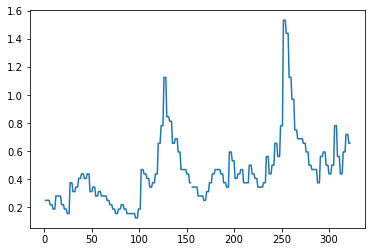

In [4]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [5]:
import copy
data_raw = copy.deepcopy(data)

### Interpolation

In [6]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [7]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [8]:
# drop NaN value in dataframe data
data = data.dropna()

In [9]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [10]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [11]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [12]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [13]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-13-86623d2f7eed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Hs [m]'][i-1] = y_fc(i)
<ipython-input-13-86623d2f7eed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Hs [m]'][i-1] = y_fq(i)
<ipython-input-13-86623d2f7eed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Hs [m]'][i-1] = y_fl(i)


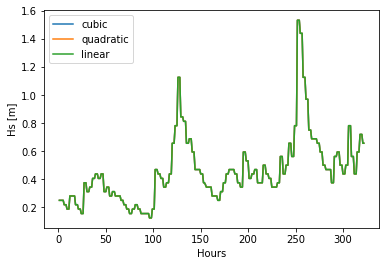

In [14]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

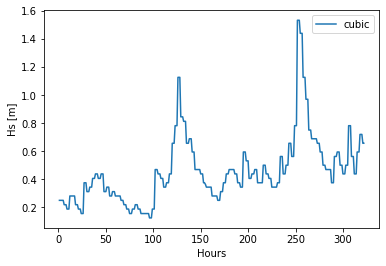

In [15]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

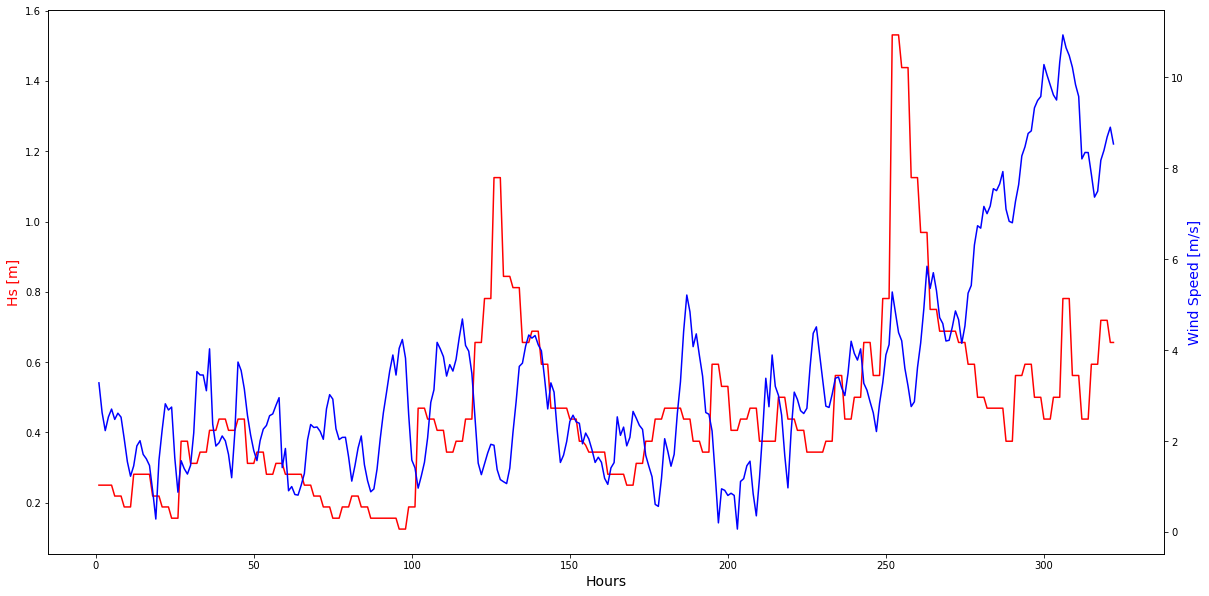

In [16]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

## splitting data

In [17]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


values = data2.values
values = values[:,2:]
values

array([[0.25, 3.27800926963222],
       [0.25, 2.62527760832271],
       [0.25, 2.22787933046239],
       [0.25, 2.5285534216261],
       [0.25, 2.70153589862244],
       [0.219, 2.47416101553726],
       [0.219, 2.61128069989766],
       [0.219, 2.5231286515699],
       [0.188, 2.04885299770812],
       [0.188, 1.54355589026629],
       [0.188, 1.22439445840067],
       [0.281, 1.45212590378417],
       [0.281, 1.89079327352315],
       [0.281, 2.0061968265788],
       [0.281, 1.7047386522141],
       [0.281, 1.60764709500286],
       [0.281, 1.46062237332241],
       [0.219, 0.906403584722278],
       [0.219, 0.283011673063272],
       [0.219, 1.57929080686855],
       [0.188, 2.23867885296378],
       [0.188, 2.81801867172457],
       [0.188, 2.68107581159384],
       [0.156, 2.74563992080808],
       [0.156, 1.62983937642129],
       [0.156, 0.873238587248627],
       [0.375, 1.56637396314664],
       [0.375, 1.38966087142673],
       [0.375, 1.27221679397903],
       [0.312, 1.465

In [18]:
# ensure all data is float
values = values.astype('float32')

In [19]:
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# scaled 

In [20]:
# frame as supervised learning
reframed = series_to_supervised(values, 2, 1) #data, window width , output size
reframed.head()

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
2,0.25,3.278009,0.250,2.625278,0.250,2.227879
3,0.25,2.625278,0.250,2.227879,0.250,2.528553
4,0.25,2.227879,0.250,2.528553,0.250,2.701536
5,0.25,2.528553,0.250,2.701536,0.219,2.474161
6,0.25,2.701536,0.219,2.474161,0.219,2.611281


In [21]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[-1], axis=1, inplace=True)
print(reframed.head())

   var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  var1(t)
2       0.25   3.278009      0.250   2.625278    0.250
3       0.25   2.625278      0.250   2.227879    0.250
4       0.25   2.227879      0.250   2.528553    0.250
5       0.25   2.528553      0.250   2.701536    0.219
6       0.25   2.701536      0.219   2.474161    0.219


In [22]:
reframed.shape


(320, 5)

In [23]:
len(reframed)

320

In [24]:
values = reframed.values

In [25]:
# split into train and test sets
train = values[:round(len(reframed)*0.7), :]
val = values[round(len(reframed)*0.7) : round(len(reframed)*0.8) , :]
test = values[round(len(reframed)*0.8):, :]

In [26]:
n_hours = 2
n_features = 2
n_obs = n_hours * n_features
X_train1, y_train1 =train[:, :n_obs], train[:, -1]
X_val1, y_val1 = val[:, :n_obs], val[:, -1]
X_test1, y_test1 = test[:, :n_obs], test[:, -1]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((224, 4), (224,), (32, 4), (32,), (64, 4), (64,))

In [27]:
# reshape input to be 3D [samples, timesteps, features]
X_train1 = X_train1.reshape((X_train1.shape[0],n_hours , n_features))
X_val1 = X_val1.reshape((X_val1.shape[0],n_hours,n_features))
X_test1 = X_test1.reshape((X_test1.shape[0], n_hours, n_features))
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((224, 2, 2), (224,), (32, 2, 2), (32,), (64, 2, 2), (64,))

## Model

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((2, 2)))
model1.add(LSTM(200, activation='relu'))
model1.add((Dense(100, activation='relu')))
model1.add((Dense(1)))
model1.summary()

model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 200)               162400    
                                                                 
 dense_13 (Dense)            (None, 100)               20100     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 182,601
Trainable params: 182,601
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 200)               162400    
                                                                 
 dense_13 (Dense)         

In [146]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [147]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
1/7 [===>..........................] - ETA: 8s - loss: 0.2175 - root_mean_squared_error: 0.4663

7/7 [==============================] - 3s 272ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499 - val_loss: 0.6969 - val_root_mean_squared_error: 0.8348
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2064 - root_mean_squared_error: 0.4543

7/7 [==============================] - 1s 242ms/step - loss: 0.1726 - root_mean_squared_error: 0.4154 - val_loss: 0.6128 - val_root_mean_squared_error: 0.7828
Epoch 3/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1098 - root_mean_squared_error: 0.3314

7/7 [==============================] - 2s 307ms/step - loss: 0.1450 - root_mean_squared_error: 0.3808 - val_loss: 0.5380 - val_root_mean_squared_error: 0.7335
Epoch 4/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1455 - root_mean_squared_error: 0.3814

7/7 [==============================] - 2s 280ms/step - loss: 0.1228 - root_mean_squared_error: 0.3504 - val_loss: 0.4715 - val_root_mean_squared_error: 0.6867
Epoch 5/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0944 - root_mean_squared_error: 0.3073

7/7 [==============================] - 2s 328ms/step - loss: 0.1038 - root_mean_squared_error: 0.3221 - val_loss: 0.4163 - val_root_mean_squared_error: 0.6452
Epoch 6/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0765 - root_mean_squared_error: 0.2765

7/7 [==============================] - 2s 250ms/step - loss: 0.0887 - root_mean_squared_error: 0.2978 - val_loss: 0.3690 - val_root_mean_squared_error: 0.6075
Epoch 7/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0873 - root_mean_squared_error: 0.2955

7/7 [==============================] - 1s 242ms/step - loss: 0.0762 - root_mean_squared_error: 0.2761 - val_loss: 0.3286 - val_root_mean_squared_error: 0.5732
Epoch 8/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0560 - root_mean_squared_error: 0.2366

7/7 [==============================] - 1s 236ms/step - loss: 0.0663 - root_mean_squared_error: 0.2574 - val_loss: 0.2932 - val_root_mean_squared_error: 0.5415
Epoch 9/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0310 - root_mean_squared_error: 0.1760

7/7 [==============================] - 1s 238ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411 - val_loss: 0.2628 - val_root_mean_squared_error: 0.5127
Epoch 10/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.2099

7/7 [==============================] - 2s 361ms/step - loss: 0.0520 - root_mean_squared_error: 0.2281 - val_loss: 0.2358 - val_root_mean_squared_error: 0.4856
Epoch 11/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0380 - root_mean_squared_error: 0.1949

7/7 [==============================] - 2s 318ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.2125 - val_root_mean_squared_error: 0.4609
Epoch 12/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0615 - root_mean_squared_error: 0.2480

7/7 [==============================] - 1s 239ms/step - loss: 0.0433 - root_mean_squared_error: 0.2080 - val_loss: 0.1929 - val_root_mean_squared_error: 0.4393
Epoch 13/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.2121

7/7 [==============================] - 1s 240ms/step - loss: 0.0401 - root_mean_squared_error: 0.2003 - val_loss: 0.1771 - val_root_mean_squared_error: 0.4208
Epoch 14/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0286 - root_mean_squared_error: 0.1691

7/7 [==============================] - 1s 237ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.1636 - val_root_mean_squared_error: 0.4045
Epoch 15/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.1538

7/7 [==============================] - 1s 239ms/step - loss: 0.0363 - root_mean_squared_error: 0.1906 - val_loss: 0.1537 - val_root_mean_squared_error: 0.3921
Epoch 16/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0680 - root_mean_squared_error: 0.2608

7/7 [==============================] - 2s 334ms/step - loss: 0.0354 - root_mean_squared_error: 0.1882 - val_loss: 0.1448 - val_root_mean_squared_error: 0.3805
Epoch 17/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0531 - root_mean_squared_error: 0.2305

7/7 [==============================] - 1s 240ms/step - loss: 0.0340 - root_mean_squared_error: 0.1845 - val_loss: 0.1398 - val_root_mean_squared_error: 0.3739
Epoch 18/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1198

7/7 [==============================] - 2s 283ms/step - loss: 0.0328 - root_mean_squared_error: 0.1811 - val_loss: 0.1374 - val_root_mean_squared_error: 0.3706
Epoch 19/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.2206

7/7 [==============================] - 2s 297ms/step - loss: 0.0316 - root_mean_squared_error: 0.1779 - val_loss: 0.1336 - val_root_mean_squared_error: 0.3656
Epoch 20/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.1541

7/7 [==============================] - 1s 242ms/step - loss: 0.0305 - root_mean_squared_error: 0.1747 - val_loss: 0.1318 - val_root_mean_squared_error: 0.3631
Epoch 21/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.2055

7/7 [==============================] - 2s 330ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711 - val_loss: 0.1301 - val_root_mean_squared_error: 0.3608
Epoch 22/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0915

7/7 [==============================] - 1s 236ms/step - loss: 0.0280 - root_mean_squared_error: 0.1674 - val_loss: 0.1264 - val_root_mean_squared_error: 0.3556
Epoch 23/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.2191

7/7 [==============================] - 1s 232ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 24/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1268

7/7 [==============================] - 1s 241ms/step - loss: 0.0255 - root_mean_squared_error: 0.1596 - val_loss: 0.1207 - val_root_mean_squared_error: 0.3474
Epoch 25/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1189

7/7 [==============================] - 1s 236ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.1165 - val_root_mean_squared_error: 0.3414
Epoch 26/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0319 - root_mean_squared_error: 0.1787

7/7 [==============================] - 2s 405ms/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3353
Epoch 27/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1137

7/7 [==============================] - 2s 266ms/step - loss: 0.0217 - root_mean_squared_error: 0.1473 - val_loss: 0.1095 - val_root_mean_squared_error: 0.3309
Epoch 28/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0366 - root_mean_squared_error: 0.1914

7/7 [==============================] - 1s 234ms/step - loss: 0.0204 - root_mean_squared_error: 0.1430 - val_loss: 0.1053 - val_root_mean_squared_error: 0.3245
Epoch 29/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0979

7/7 [==============================] - 1s 234ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.1026 - val_root_mean_squared_error: 0.3203
Epoch 30/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.1286

7/7 [==============================] - 1s 234ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0998 - val_root_mean_squared_error: 0.3159
Epoch 31/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.1267

7/7 [==============================] - 2s 329ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0966 - val_root_mean_squared_error: 0.3108
Epoch 32/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1257

7/7 [==============================] - 1s 240ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0933 - val_root_mean_squared_error: 0.3054
Epoch 33/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0305 - root_mean_squared_error: 0.1746

7/7 [==============================] - 2s 257ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0901 - val_root_mean_squared_error: 0.3001
Epoch 34/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0213 - root_mean_squared_error: 0.1458

7/7 [==============================] - 2s 385ms/step - loss: 0.0135 - root_mean_squared_error: 0.1161 - val_loss: 0.0876 - val_root_mean_squared_error: 0.2959
Epoch 35/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1140

7/7 [==============================] - 2s 370ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0850 - val_root_mean_squared_error: 0.2915
Epoch 36/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0952

7/7 [==============================] - 2s 325ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0809 - val_root_mean_squared_error: 0.2844
Epoch 37/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.1275

7/7 [==============================] - 1s 238ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2772
Epoch 38/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0969

7/7 [==============================] - 1s 240ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2681
Epoch 39/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0742

7/7 [==============================] - 1s 237ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0713 - val_root_mean_squared_error: 0.2670
Epoch 40/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0601

7/7 [==============================] - 1s 247ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0689 - val_root_mean_squared_error: 0.2625
Epoch 41/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1332

7/7 [==============================] - 2s 319ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0673 - val_root_mean_squared_error: 0.2595
Epoch 42/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0947

7/7 [==============================] - 2s 356ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0634 - val_root_mean_squared_error: 0.2518
Epoch 43/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0940

7/7 [==============================] - 1s 240ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0616 - val_root_mean_squared_error: 0.2482
Epoch 44/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2497
Epoch 45/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0628

7/7 [==============================] - 1s 240ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0591 - val_root_mean_squared_error: 0.2432
Epoch 46/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1329

7/7 [==============================] - 1s 240ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 47/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0554 - val_root_mean_squared_error: 0.2353
Epoch 48/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0871

7/7 [==============================] - 1s 231ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 49/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0773

7/7 [==============================] - 2s 311ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0530 - val_root_mean_squared_error: 0.2303
Epoch 50/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0685

7/7 [==============================] - 2s 290ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2255
Epoch 51/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0870

7/7 [==============================] - 2s 290ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2231
Epoch 52/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0705

7/7 [==============================] - 1s 247ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2216
Epoch 53/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0566

7/7 [==============================] - 1s 235ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2189
Epoch 54/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0945

7/7 [==============================] - 2s 318ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2180
Epoch 55/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0541

7/7 [==============================] - 1s 241ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2147
Epoch 56/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0669

7/7 [==============================] - 1s 235ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2107
Epoch 57/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2110
Epoch 58/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2117
Epoch 59/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0919

7/7 [==============================] - 1s 236ms/step - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2086
Epoch 60/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0716

7/7 [==============================] - 2s 301ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2031
Epoch 61/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2052
Epoch 62/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2055
Epoch 63/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0498

7/7 [==============================] - 2s 365ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2024
Epoch 64/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0798

7/7 [==============================] - 2s 305ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1991
Epoch 65/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2004
Epoch 66/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2000
Epoch 67/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0687

7/7 [==============================] - 1s 240ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1981
Epoch 68/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0479

7/7 [==============================] - 1s 246ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1971
Epoch 69/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 70/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0441

7/7 [==============================] - 1s 235ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953
Epoch 71/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1967
Epoch 72/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1953
Epoch 73/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1968
Epoch 74/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 75/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0507

7/7 [==============================] - 2s 320ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943
Epoch 76/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1959
Epoch 77/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 78/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 79/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 80/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0382 - val_root_mean_squared_

In [168]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [169]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Multivariate':train_predictions, 'Actuals':y_train1})
train_results

7/7 [==============================] - 0s 3ms/step


,Multivariate,Actuals
0,0.282593,0.250
1,0.279184,0.250
2,0.263614,0.250
3,0.265625,0.219
4,0.262389,0.219
...,...,...
219,0.409648,0.406
220,0.414148,0.406
221,0.402335,0.406
222,0.397568,0.344


In [150]:
# # invert scalling 
# inv_train_results = scaler.inverse_transform(train_results)
# inv_train_results = pd.DataFrame(inv_train_results )
# inv_train_results 

In [151]:
# # change the column name
# inv_train_results.columns = ['Train Predictions', 'Actuals']
# inv_train_results

In [170]:
train_results['Date'] = data2['Date'].iloc[4:round(len(values)*0.7)]
train_results.head()

,Multivariate,Actuals,Date
0,0.282593,0.250,NaT
1,0.279184,0.250,NaT
2,0.263614,0.250,NaT
3,0.265625,0.219,NaT
4,0.262389,0.219,1998-10-30 08:00:00


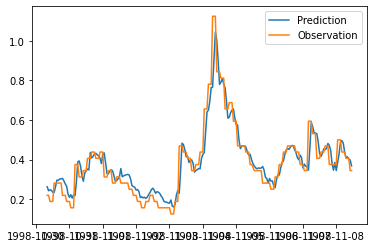

In [171]:
import matplotlib.pyplot as plt
plt.plot(train_results['Date'],train_results['Multivariate'], label ='Prediction')
plt.plot(train_results['Date'],train_results['Actuals'], label='Observation')
plt.legend(loc='best')

In [172]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_results['Date'], y=train_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Training'))
fig.add_trace(go.Scatter(x=train_results['Date'], y=train_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [155]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Multivariate':val_predictions, 'Actuals':y_val1})
val_results.head()

1/1 [==============================] - 0s 16ms/step


,Multivariate,Actuals
0,0.323687,0.344
1,0.323552,0.344
2,0.331303,0.344
3,0.350963,0.344
4,0.355500,0.375


In [156]:
val_results['Date'] = data2['Date'].iloc[round(len(reframed)*0.7):round(len(reframed)*0.8)].values
val_results.head()

,Multivariate,Actuals,Date
0,0.323687,0.344,1998-11-08 12:00:00
1,0.323552,0.344,1998-11-08 13:00:00
2,0.331303,0.344,1998-11-08 14:00:00
3,0.350963,0.344,1998-11-08 15:00:00
4,0.355500,0.375,1998-11-08 16:00:00


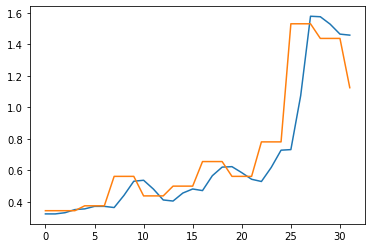

In [157]:
plt.plot(val_results['Multivariate'][:100])
plt.plot(val_results['Actuals'][:100])

In [158]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=val_results['Date'], y=val_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Validation'))
fig.add_trace(go.Scatter(x=val_results['Date'], y=val_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [159]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Multivariate':test_predictions, 'Actuals':y_test1})
test_results.head()

2/2 [==============================] - 0s 4ms/step


,Multivariate,Actuals
0,1.309126,1.125
1,1.112861,1.125
2,1.105356,0.969
3,1.019271,0.969
4,0.912833,0.969


In [160]:
test_results['Date'] = data2['Date'].iloc[round(len(reframed)*0.8):round(len(reframed))].values
test_results.head()

,Multivariate,Actuals,Date
0,1.309126,1.125,1998-11-09 20:00:00
1,1.112861,1.125,1998-11-09 21:00:00
2,1.105356,0.969,1998-11-09 22:00:00
3,1.019271,0.969,1998-11-09 23:00:00
4,0.912833,0.969,1998-11-10 00:00:00


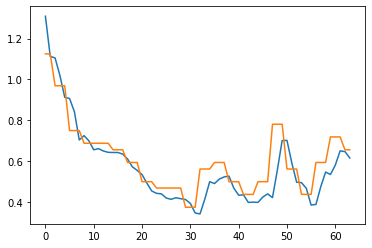

In [161]:
plt.plot(test_results['Multivariate'])
plt.plot(test_results['Actuals'])

In [162]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [163]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Multivariate'])
RMSE = math.sqrt(MSE)
RMSE

0.09519311216751923

In [164]:

from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Multivariate'])
corr

0.8932422434105209

In [165]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Multivariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

-0.036316672805696726

In [166]:
train_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_train_lstm_masalembo.csv')
val_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_val_lstm_masalembo.csv')
test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_test_lstm_masalembo.csv')

In [167]:
# serialize weights to HDF5
model1.save_weights("/content/drive/MyDrive/TA (1)/Learn to Code ML/Model/model_multivariate_masalembo.h5")
print("Model Saved !")

Model Saved !
